In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# А/А-тестирование мобильного приложения

#### Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

In [2]:
aa = pd.read_csv('aa.csv', sep=';')

#### Описание колонок
**experimentVariant** – вариант эксперимента<br/>
**version** – версия приложения<br/>
**purchase** – факт покупки

In [6]:
aa.head()

,experimentVariant,version,purchase
0,1,v2.8.0,0
1,0,v2.9.0,0
2,1,v2.9.0,0
3,1,v2.8.0,0
4,1,v2.8.0,0


In [9]:
aa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   experimentVariant  127018 non-null  int64 
 1   version            127018 non-null  object
 2   purchase           127018 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.9+ MB


In [14]:
#разделим дф на 2: эксперементальная группа 0 и эксперементальная группа 1
aa_0 = aa.query("experimentVariant == 0")
aa_1 = aa.query("experimentVariant == 1")

## **Запускаем A/A тест**

**Посчитаем результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку)** <br/>
α == 0.05

  0%|          | 0/1000 [00:00<?, ?it/s]

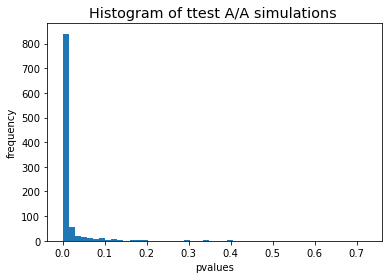

0.93

In [15]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = aa_0['purchase'].sample(n_s, replace = False).values
    s2 = aa_1['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

##### A/A тест не сходится !!!

**FPR > α** (0.924 > 0.05)

### Ищем причины поломки сплит-системы

Считаем конверсию (коэффициент покупок), по варианту и версии мобильного приложения

In [19]:
aa_0_conversion = aa_0.groupby('version', as_index=False)\
                    .agg({'purchase': 'sum', 'experimentVariant':'count'})\
                    .rename(columns={'experimentVariant':'total_purchase'})
aa_0_conversion['conversion']=(aa_0_conversion.purchase*100/aa_0_conversion.total_purchase).round(3)

In [20]:
aa_0_conversion

,version,purchase,total_purchase,conversion
0,v2.8.0,41,41283,0.099
1,v2.9.0,890,11921,7.466
2,v3.7.4.0,252,4204,5.994
3,v3.8.0.0,328,5694,5.760


In [21]:
aa_1_conversion = aa_1.groupby('version', as_index=False)\
                    .agg({'purchase': 'sum', 'experimentVariant':'count'})\
                    .rename(columns={'experimentVariant':'total_purchase'})
aa_1_conversion['conversion']=(aa_1_conversion.purchase*100/aa_0_conversion.total_purchase).round(3)

In [22]:
aa_1_conversion

,version,purchase,total_purchase,conversion
0,v2.8.0,1895,41552,4.590
1,v2.9.0,858,12033,7.197
2,v3.7.4.0,266,4221,6.327
3,v3.8.0.0,384,6110,6.744


*На данном этапе выделяется разница в конверсии v2.8.0 (0,099 в 0 группе и 4,590 в 1 группе)*

**Рассчитываем p-value для каждой версии мобильного приложения**


In [23]:
from scipy.stats import norm, mannwhitneyu

In [32]:
print('p-value v2.8.0:',mannwhitneyu(aa.query("version == 'v2.8.0' & experimentVariant == 0")['purchase'], aa.query("version == 'v2.8.0' & experimentVariant == 1")['purchase'])[1])
print('p-value v2.9.0:',mannwhitneyu(aa.query("version == 'v2.9.0' & experimentVariant == 0")['purchase'], aa.query("version == 'v2.9.0' & experimentVariant == 1")['purchase'])[1].round(2))
print('p-value v3.7.4.0:',mannwhitneyu(aa.query("version == 'v3.7.4.0' & experimentVariant == 0")['purchase'], aa.query("version == 'v3.7.4.0' & experimentVariant == 1")['purchase'])[1].round(2))
print('p-value v3.8.0.0:',mannwhitneyu(aa.query("version == 'v3.8.0.0' & experimentVariant == 0")['purchase'], aa.query("version == 'v3.8.0.0' & experimentVariant == 1")['purchase'])[1].round(2))

p-value v2.8.0: 0.0
p-value v2.9.0: 0.32
p-value v3.7.4.0: 0.56
p-value v3.8.0.0: 0.23


##### Итого, pvalue < 0.05 только у версии v2.8.0. Исключаем его из дата фрейма

In [33]:
aa_0_new = aa.query("experimentVariant == 0 & version != 'v2.8.0'")
aa_1_new = aa.query("experimentVariant == 1 & version != 'v2.8.0'")

### Повторно запускаем расчет FPR через A/A

  0%|          | 0/1000 [00:00<?, ?it/s]

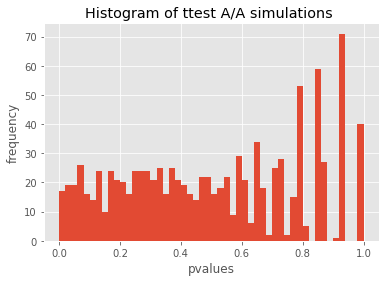

0.046

In [34]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = aa_0_new['purchase'].sample(n_s, replace = False).values
    s2 = aa_1_new['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

###### A/A тест сходится !!!

**FPR < α** (0.049 < 0.05)

### Выводы

Изначально была информация, что сплит-система сломана. Задача стояла проверить, действительно ли это так, и найти причины поломки.<br/>
1. Сплит-система действительно сломана
2. Причина поломки в сильном отличим конверсии в покупку. А именно, в версии v2.8.0
3. После исключения версии v2.8.0 из основного датафрейма мы получили FPR < α (0.049 < 0.05), что дает нам сделать вывод, что система сплитования работает корректно
4. Починить поломку получилось